In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LogNorm
%matplotlib inline

import scipy.stats
import scipy.optimize
from scipy.sparse import csr_matrix
import scipy.signal

import cv2

import os
import functools
import itertools as it

In [2]:
PIX_SIZE = .00112

DIR = os.path.join(os.getenv('HOME'), 'beam_sim')
PREFIX = 'test'

In [3]:
# get variables from config file
f_cfg = np.load('{}/{}_config.npz'.format(DIR, PREFIX))

RES_X, RES_Y = f_cfg['res']
FPS = f_cfg['fps']

f_cfg.close()


# I. Measuring Background #

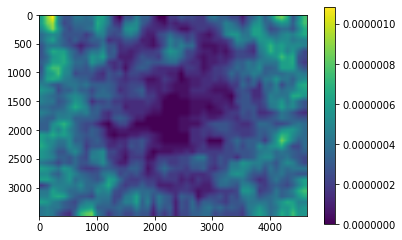

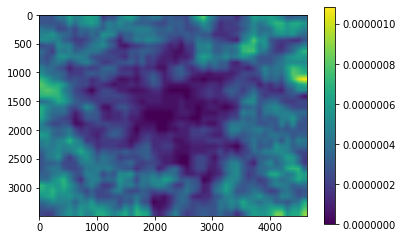

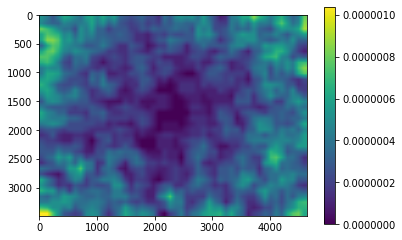

In [4]:
histograms = {}
n_frames = {}

NOISE = {}

for fname in os.listdir(os.path.join(DIR, 'bg')):
    p = fname.split('_')[0]
    if not p in histograms:
        histograms[p] = 0
        n_frames[p] = 0
    
    f = np.load(os.path.join(DIR, 'bg', fname))
    
    histograms[p] += csr_matrix((np.ones(f['x'].size), (f['x'], f['y'])), shape=(RES_X,RES_Y))
    n_frames[p] += 1
    
    f.close()
    
downsample = 97

for p,h in histograms.items():
    downscale = h.toarray().reshape(RES_X//downsample, downsample, RES_Y//downsample, downsample).sum((1,3))
    downscale = scipy.signal.convolve2d(downscale, np.ones((3,3))/9, mode='same', boundary='symm')
    NOISE[p] = cv2.resize(downscale, (RES_Y, RES_X)) / n_frames[p] / downsample**2
    
    plt.figure()
    plt.imshow(NOISE[p].transpose(), cmap='viridis')
    plt.colorbar()

# II. Sorting the Data #

We first need to sort the phone data into spills by time.  But this first requires doing drift correction:

In [5]:
class Spill(dict):
    def __init__(self):
        pass
    
    def append(self, phone, t):
        if not phone in self.keys():
            self[phone] = [t]
        else:
            self[phone].append(t)
            
    def get_file(phone, t, filetype='raw'):
        return np.load('{}/{}/{}_p{}_t{}.npz'.format(DIR, filetype, PREFIX, phone, t))
    
    def histogram(self, phone, downsample=4):
        hist = 0
        
        for t in self[phone]:
            f = Spill.get_file(phone, t)
            res_y_down = RES_Y // downsample
            res_x_down = RES_X // downsample
            hist += np.histogram2d(f.f.y, f.f.x, bins=(res_y_down, res_x_down), range=((0, RES_Y),(0, RES_X)))[0]
            f.close()
        return hist

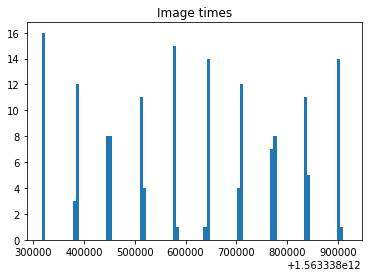

In [6]:
phones = []
t_nominal = []
t_corr = []

for fname in os.listdir(DIR + '/raw/'):
    parts = (fname.split('.')[0]).split('_')
    if len(parts) != 3: continue
    iphone = parts[-2][1:]
    t = int(parts[-1][1:])
    
    # in case this is run multiple times, we use the original timestamp saved in the raw file
    f = np.load(os.path.join(DIR, 'raw', fname))
    
    phones.append(iphone)
    t_nominal.append(f.f.t)
    t_corr.append(t)
    f.close()
    
tmin = min(t_nominal)
tmax = max(t_nominal)

plt.title('Image times')
plt.hist(t_nominal, bins=100, range=(tmin, tmin+600000));

In [7]:
sorting = np.argsort(t_nominal)
t_nominal_sorted = np.array(t_nominal)[sorting]
t_corr_sorted = np.array(t_corr)[sorting]
phones_sorted = np.array(phones)[sorting]

# pick a phone to which we map the other phones' coordinates
PHONE_LIST = sorted(list(set(phones))) # remove copies
ROOT = PHONE_LIST[0]
OTHERS = PHONE_LIST.copy()
OTHERS.remove(ROOT)
print(PHONE_LIST)
print(ROOT)

COMBINATIONS = list(it.combinations(PHONE_LIST, 2))

['4175df1b613b494e', 'a415f48b88bf4087', 'd4c54e984d644540']
4175df1b613b494e


{'d4c54e984d644540': 6558.272000000715, 'a415f48b88bf4087': 5875.932000000737, '4175df1b613b494e': 6298.056000000921}


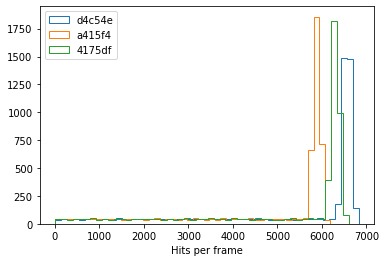

In [8]:
# find the average number of hits when the beam is on

p_arr = np.array(phones_sorted)
t_nominal_arr = np.array(t_nominal_sorted)
t_corr_arr = np.array(t_corr_sorted)

median_flux = {}

for iphone in set(phones):
    n_hits = []
    t_nominal_iphone = t_nominal_arr[p_arr == iphone]
    t_corr_iphone = t_corr_arr[p_arr == iphone]
    for t in t_corr_iphone:
        f = Spill.get_file(iphone, t)
        n_hits.append(len(f.f.x))
    plt.hist(n_hits, bins=50, histtype='step', label=iphone[:6])
    plt.xlabel('Hits per frame')
    
    # now exclude the first and last frame of each beam dump
    t_diffs = np.hstack([[1e5], np.diff(t_nominal_iphone), [1e5]]) 
    
    flux_full = np.array(n_hits)[(t_diffs[1:] < 1.5e3 / FPS) & (t_diffs[:-1] < 1.5e3 / FPS)]
    
    median_flux[iphone] = np.median(flux_full) - NOISE[iphone].sum()
    
plt.legend(loc='upper left');

print(median_flux)

In [9]:
# now get the estimated start/end intervals for each spill, by phone

spill_intervals = {}

for iphone in set(phones):
    t_corr_iphone = t_corr_arr[p_arr == iphone]
    t_nominal_iphone = t_nominal_arr[p_arr == iphone]
    t_diffs = np.hstack([[1e5], np.diff(t_nominal_iphone), [1e5]])
    
    t_len = t_corr_iphone.size
    start_args = np.arange(t_len)[(t_diffs[1:] <= 5e3) & (t_diffs[:-1] > 5e3)]
    end_args = np.arange(t_len)[(t_diffs[1:] > 5e3) & (t_diffs[:-1] <= 5e3)]
    
    t_start_corr = []
    t_end_corr = []
    
    bg = NOISE[iphone].sum()
    
    for arg in start_args:
        f = Spill.get_file(iphone, t_corr_iphone[arg])
        t_start_corr.append(t_nominal_iphone[arg] + 1000 / FPS * (1 - (len(f.f.x) - bg) / median_flux[iphone]))
        f.close()
        
    for arg in end_args: 
        f = Spill.get_file(iphone, t_corr_iphone[arg])
        t_end_corr.append(t_nominal_iphone[arg] + 1000 / FPS * (len(f.f.x) - bg) / median_flux[iphone])
        f.close()
        
    spill_intervals[iphone] = np.vstack([t_start_corr, t_end_corr])
    

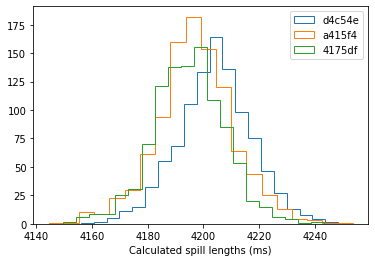

In [10]:
# now we clean these up a bit
    
# first get rid of spills from extraneous triggering
spill_lengths = np.array([])
plt.xlabel('Calculated spill lengths (ms)');
for iphone, intervals in spill_intervals.items():
    l = intervals[1] - intervals[0]
    plt.hist(l, bins=20, histtype='step', label=iphone[:6]);
    plt.legend();
    spill_lengths = np.append(l, spill_lengths)

min_spill_length = np.mean(spill_lengths) / 2

for iphone, intervals in spill_intervals.items():
    l = intervals[1] - intervals[0]
    spill_intervals[iphone] = spill_intervals[iphone][:, l > min_spill_length]
    
# then we get rid of extra spills at the beginning
first_spills = [interval[0][0] for interval in spill_intervals.values()]
min_spills = min([interval.shape[1] for interval in spill_intervals.values()])

for iphone, intervals in spill_intervals.items():
    spill_intervals[iphone] = spill_intervals[iphone][:, intervals[0] > max(first_spills) - 5000][:min_spills] 

0.9995164202208308 755998785.9692383


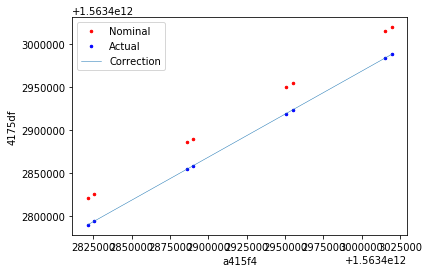

0.9977356708250372 3539912504.010254


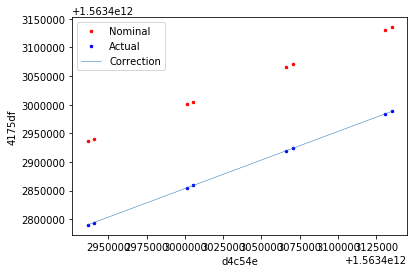

In [11]:
# finally get the linear coefficients
times_root = spill_intervals[ROOT].flatten()
times_root.sort()

m = {ROOT: 1}
b = {ROOT: 0}

for other in OTHERS:
    times_other = spill_intervals[other].flatten()
    times_other.sort()
    mi,bi,r,p,s = scipy.stats.linregress(times_other, times_root)
    print(mi,bi)
    m[other] = mi
    b[other] = bi
    
    plt.xlabel(other[:6])
    plt.ylabel(ROOT[:6])
    plt.plot(times_other[-8:], times_other[-8:], 'r.', markersize=5, label='Nominal')
    plt.plot(times_other[-8:], times_root[-8:], 'b.', markersize=5, label='Actual')
    plt.plot(times_other[-8:], mi * times_other[-8:] + bi, lw=0.5, label='Correction')
    plt.legend()
    plt.show()

In [12]:
# now rename to reflect the adjusted times
times = []
phones = []

for fname in os.listdir(DIR + '/raw/'):
    parts = (fname.split('.')[0]).split('_')
    if len(parts) != 3: continue
    iphone = parts[-2][1:]
    t = int(parts[-1][1:])
    f = np.load(os.path.join(DIR, 'raw', fname))
    t_corr = int(m[iphone] * f.f.t + b[iphone])
    f.close()
    
    phones.append(iphone)
    times.append(t_corr)
    
    f_full = os.path.join(DIR, 'raw', fname)
    os.rename(f_full, f_full.replace(str(t), str(t_corr)))

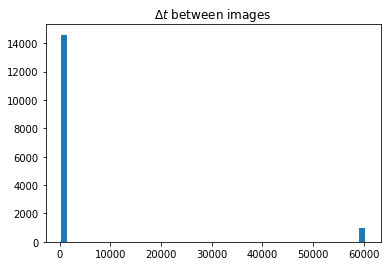

In [13]:
# redo sorting
sorting = np.argsort(times)
t_sorted = np.array(times)[sorting]
phones_sorted = np.array(phones)[sorting]

dt = np.diff(t_sorted)

plt.title(r'$\Delta t$ between images')
plt.hist(dt, bins=50);

In [14]:
# next, we separate the various spills in the files

def get_tuple(ientry):
    return phones_sorted[ientry], t_sorted[ientry]

n_phones = len(set(phones_sorted))
spills = []
spill_lengths = []
imin = 0

ispill = Spill()
iphone, t = get_tuple(0)
ispill.append(iphone, t)

for i, delta in enumerate(dt):
    iphone, t = get_tuple(i+1)
    if delta > 5000:
        spill_lengths.append(t_sorted[i] - t_sorted[imin])
        imin = i+1
        spills.append(ispill)
        # create a new spill
        ispill = Spill()
    
    ispill.append(iphone, t)

spill_lengths.append(max(t_sorted) - t_sorted[imin])
spills.append(ispill)

# III. Alignment #

### Truth values ###

We need coordinates that will be useful for finding the true mapping from sensor to lab.  In Eulerian angles, we have:

$x_l=(x_s+x_0)(\cos\psi\cos\theta\cos\phi - \sin\psi\sin\phi) - (y_s+y_0)(\sin\psi\cos\theta\cos\phi -\cos\psi\sin\phi)$
$y_l=(x_s+x_0)(\cos\psi\cos\theta\sin\phi + \sin\psi\cos\phi) - (y_s+y_0)(\sin\psi\cos\theta\sin\phi +\cos\psi\cos\phi)$

First, we can redefine the offsets in terms of the lab frame:

$x_l=x_{l0} + x_s(\cos\psi\cos\theta\cos\phi - \sin\psi\sin\phi) - y_s(\sin\psi\cos\theta\cos\phi -\cos\psi\sin\phi)$
$y_l=y_{l0} + x_s(\cos\psi\cos\theta\sin\phi + \sin\psi\cos\phi) - y_s(\sin\psi\cos\theta\sin\phi +\cos\psi\cos\phi)$

Since the phones are more or less aligned, we expect that $\psi\approx -\phi$.  If we write $\psi=-\phi+\delta$, then in matrix notation:

$
\begin{pmatrix}
x \\
y
\end{pmatrix}
= \begin{pmatrix}
x_{l0} \\
y_{l0}
\end{pmatrix}
+
\begin{pmatrix}
\cos\phi & -\sin\phi \\
\sin\phi & \cos\phi
\end{pmatrix}
\begin{pmatrix}
\cos\theta & 0 \\
0 & 1
\end{pmatrix}
\begin{pmatrix}
\cos\phi & \sin\phi \\
-\sin\phi & \cos\phi
\end{pmatrix}
\begin{pmatrix}
\cos\delta & -\sin\delta \\
\sin\delta & \cos\delta
\end{pmatrix}
\begin{pmatrix}
x_s \\
y_s
\end{pmatrix}
$

The rightmost of these four transformations is a rotation in the lab space, whereas the others compress the sensor coordinates about some axis.  Multiplying these matrices together and simplifying, we see that:

$
\begin{pmatrix}
\cos\phi & -\sin\phi \\
\sin\phi & \cos\phi
\end{pmatrix}
\begin{pmatrix}
\cos\theta & 0 \\
0 & 1
\end{pmatrix}
\begin{pmatrix}
\cos\phi & \sin\phi \\
-\sin\phi & \cos\phi
\end{pmatrix} =
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}
- (1 - \cos\theta)
\begin{pmatrix}
\cos\phi & \sin\phi
\end{pmatrix}
\begin{pmatrix}
\cos\phi \\ \sin\phi
\end{pmatrix}
$

$= \mathbf{1} - \mathbf{v}\cdot\mathbf{v}^T$

for some vector $\mathbf{v}$ with components between 0 and 1.  While we do not know the offset, we can expect that $\delta\approx 0$ and $\mathbf{v} \approx \mathbf{0}$

Furthermore,

$ (\mathbf{1} - \mathbf{v}\cdot\mathbf{v}^T)^{-1} = \mathbf{1} + \frac{\mathbf{v}\cdot\mathbf{v}^T}{\det(\mathbf{1} - \mathbf{v}\cdot\mathbf{v}^T)}$

and so we can model the combined effect of two of these transformations as:

$ UV^{-1} = \mathbf{1} - \mathbf{u}\cdot\mathbf{u}^T + \mathbf{v'}\cdot\mathbf{v'}^T + O(\mathbf{u}^2, \mathbf{v'}^2) \\
= \mathbf{1} - \begin{pmatrix}
u_x & u_{xy} \\
u_{xy} & u_y
\end{pmatrix} $

### Finding the mapping parameters ###

We can find a coarse estimate of $dx$ and $dy$ by comparing beam profiles.

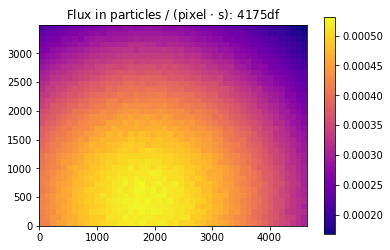

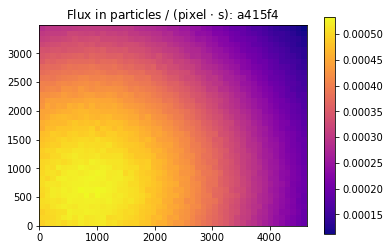

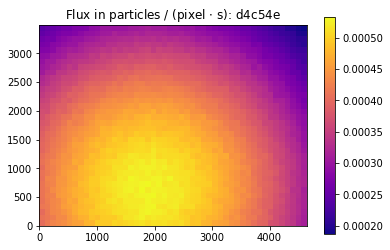

In [15]:
hists = {p:0 for p in PHONE_LIST}
downsample=97
noise_grids = {p: NOISE[p].reshape(RES_X//downsample, downsample, RES_Y//downsample, downsample).sum((1,3)).transpose() \
               for p in PHONE_LIST}

for spl in spills:
    for p in PHONE_LIST:
        hist_i = spl.histogram(p, downsample=downsample)
        hists[p] += hist_i - noise_grids[p]
        
for p in hists:
    plt.figure()
    plt.title(r'Flux in particles / (pixel $\cdot$ s): {}'.format(p[:6]))
    plt.imshow(hists[p] / downsample**2 / len(spills) / 4.2, cmap='plasma', origin='lower', extent=[0, RES_X, 0, RES_Y]);
    plt.colorbar();

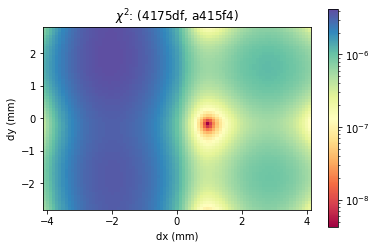

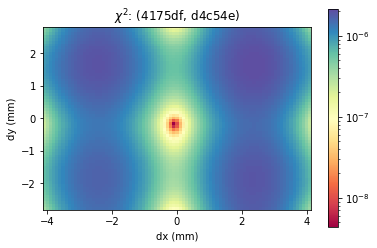

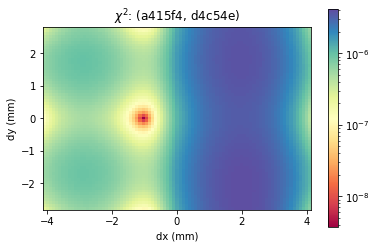

In [16]:
def chisq_offset(hist1, hist2, dx, dy):
    if dy > 0:
        hist1 = hist1[dy:,:]
        hist2 = hist2[:-dy, :]
    elif dy < 0:
        hist1 = hist1[:dy,:]
        hist2 = hist2[-dy:, :]
    
    if dx > 0:
        hist1 = hist1[:,dx:]
        hist2 = hist2[:,:-dx]
    elif dx < 0:
        hist1 = hist1[:, :dx]
        hist2 = hist2[:, -dx:]
        
    return np.sum((hist1/hist1.mean() - hist2/hist2.mean())**2/(hist1 + hist2)) / hist1.size

min_intersection = 5
shape = list(hists.values())[0].shape
chisq_grids = {c: np.array([[chisq_offset(hists[c[0]], hists[c[1]], x, y) \
                       for x in np.arange(-shape[1]+min_intersection, shape[1]-min_intersection+1)] \
                       for y in np.arange(-shape[0]+min_intersection, shape[0]-min_intersection+1)]) \
               for c in COMBINATIONS}
                       
sx = downsample*(shape[1] - 2*min_intersection)*PIX_SIZE 
sy = downsample*(shape[0] - 2*min_intersection)*PIX_SIZE

dxy_all = {}

for c, grid in chisq_grids.items():
    plt.figure()
    plt.title(r'$\chi^2$: ({}, {})'.format(c[0][:6], c[1][:6]))
    plt.xlabel('dx (mm)')
    plt.ylabel('dy (mm)')
    plt.imshow(grid, cmap='Spectral', norm=LogNorm(), extent=[-sx, sx, -sy, sy], origin='lower');
    plt.colorbar();

    iy, ix = np.unravel_index(np.argmin(grid), grid.shape)

    dxy_all[c] = (ix / (grid.shape[1]-1) * 2 * sx - sx, iy / (grid.shape[0]-1) * 2 * sy - sy)

In [17]:
# now pick a root frame to map coordinates
furthest = 0
ROOT = None
for c,xy in dxy_all.items():
    dsq = xy[0]**2 + xy[1]**2
    if dsq > furthest:
        furthest = dsq
        OTHERS = list(c)
        ROOT = list(set(PHONE_LIST) - set(OTHERS))[0]
        
print('ROOT:', ROOT)

dxy_coarse = {}
for c,xy in dxy_all.items():
    if ROOT == c[0]:
        dxy_coarse[c[1]] = xy
    elif ROOT == c[1]:
        dxy_coarse[c[0]] = (-xy[0], -xy[1])
        
print(dxy_coarse)

ROOT: 4175df1b613b494e
{'a415f48b88bf4087': (0.960074418604651, -0.1822348387096775), 'd4c54e984d644540': (-0.09600744186046484, -0.1822348387096775)}


XY:
abs
[[1.62078448 1.26245511]
 [0.55396024 1.18278501]
 [0.74017166 1.38479693]]
diff
[[ 0.          0.        ]
 [ 0.8898667   0.00164417]
 [-0.1571912  -0.22684865]]

phi:
[ 0.44779295 -0.50210272 -2.02568314]
abs
[ 0.01971021 -0.07981574 -0.13806288]
diff
[0.         0.15777309 0.05824714]

u:
[[-4.13452305e-06 -8.45338934e-06 -1.72836844e-05]
 [ 1.25759198e-04 -1.34029322e-03 -3.50764281e-03]
 [-7.13316196e-04 -1.93080930e-03 -3.68835672e-03]]


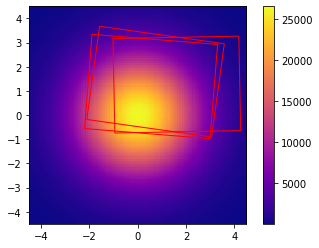

In [18]:
# we convert the truth results to these new coordinates with the given ROOT
ftruth = np.load('{}/{}_truth.npz'.format(DIR, PREFIX))

fig = plt.figure()
ax = fig.gca()

# first draw beam profile
spot_size = 6
beam_xy = scipy.stats.multivariate_normal(mean=[0,0], cov=spot_size/2)
n_particles=5e5
sz = 1.5*spot_size
x = np.linspace(-sz/2, sz/2, 100)
y = np.linspace(-sz/2, sz/2, 100)
pos = np.dstack(np.meshgrid(x,y))
intensity = n_particles*beam_xy.pdf(pos)
plt.imshow(intensity, extent=2*[-sz/2, sz/2], cmap='plasma', origin='lower')
plt.colorbar()

# next add rectangles for each phone
n_phones = ftruth.f.hwid.size

RES = (4656, 3492)
lim_x = RES[0] * PIX_SIZE / 2
lim_y = RES[1] * PIX_SIZE / 2
rects = np.repeat(np.array([[
        [-lim_x, -lim_y],
        [lim_x, -lim_y],
        [lim_x, lim_y],
        [-lim_x, lim_y]]]), n_phones, axis=0)

# do rotations

cos_phi = np.cos(ftruth.f.phi)
sin_phi = np.sin(ftruth.f.phi)
phi_mat = np.array([[cos_phi, -sin_phi], [sin_phi, cos_phi]])

theta_mat = np.array([
    [np.cos(ftruth.f.theta), np.zeros(n_phones)],
    [np.zeros(n_phones), np.ones(n_phones)]
    ])

cos_psi = np.cos(ftruth.f.psi)
sin_psi = np.sin(ftruth.f.psi)
psi_mat = np.array([[cos_psi, -sin_psi], [sin_psi, cos_psi]])

# need to rotate to frame of root phone for the right "truth" coords

root_idx = np.argwhere(ftruth.f.hwid == ROOT)[0]
delta0 = ftruth.f.phi[root_idx] + ftruth.f.psi[root_idx]
cos_delta = np.cos(delta0)[0]
sin_delta = np.sin(delta0)[0]
delta_mat = np.array([[cos_delta, sin_delta], [-sin_delta, cos_delta]])

xy_lab_truth = dict(zip(ftruth.f.hwid, np.dstack([ftruth.f.x, ftruth.f.y])[0]))

for iphone, phone in enumerate(ftruth.f.hwid):

    for corner in range(4):
        psi_rot_c = np.matmul(psi_mat[:,:,iphone], rects[iphone][corner])
        theta_rot_c = np.matmul(theta_mat[:,:,iphone], psi_rot_c)
        rects[iphone][corner] = np.matmul(phi_mat[:,:,iphone], theta_rot_c) + xy_lab_truth[phone]


phi_adj = np.mod(ftruth.f.phi, np.pi) - np.pi # same transformation mod pi

v_truth = dict(zip(ftruth.f.hwid, \
        np.sqrt(1-np.cos(ftruth.f.theta)).reshape(-1,1) * np.dstack([np.cos(phi_adj), np.sin(phi_adj)])[0]))
vinv_ROOT = v_truth[ROOT]/np.sqrt(1 - np.inner(v_truth[ROOT], v_truth[ROOT]))
scale_root = np.eye(2) + np.outer(vinv_ROOT, vinv_ROOT)
scale_mats = {p: np.eye(2) - np.outer(v_truth[p], v_truth[p]) for p in PHONE_LIST}

print("XY:")
print("abs")
print(np.array(list(xy_lab_truth.values())))
dxy_truth = {p: functools.reduce(np.matmul, [scale_root, delta_mat, xy_lab_truth[p] - xy_lab_truth[ROOT]]) for p in PHONE_LIST}
print("diff")
print(np.array(list(dxy_truth.values())))
print()

print("phi:")
print(ftruth.f.phi)
phi_lab_truth = dict(zip(ftruth.f.hwid, ftruth.f.phi + ftruth.f.psi))
print("abs")
print(np.array(list(phi_lab_truth.values())))
dphi_truth = {p: phi_lab_truth[p] - phi_lab_truth[ROOT] for p in PHONE_LIST}
print("diff")
print(np.array(list(dphi_truth.values())))
print()

print("u:")
u_truth = {p: np.array([v_truth[p][0]**2 - vinv_ROOT[0]**2, \
                        v_truth[p][0] * v_truth[p][1] - vinv_ROOT[0] * vinv_ROOT[1], \
                        v_truth[p][1]**2 - vinv_ROOT[1]**2]) \
           for p in PHONE_LIST}
#u_truth = {p: np.dot(scale_root, scale_mats[p]) for p in PHONE_LIST}
print(np.array(list(u_truth.values())))

align_truth = {p: np.hstack([dxy_truth[p], dphi_truth[p], u_truth[p]]) for p in PHONE_LIST}

polygons = [Polygon(rects[iphone]) for iphone in range(n_phones)]
p = PatchCollection(polygons, edgecolors='r', facecolors='none', linewidths=1)
ax.add_collection(p);

Now, we can do some finer adjustment which includes $\phi$.  Calculating the cdf for the nearest pixel from another frame:

$dp = 2\pi n r dr$

$1 - F(r) = \prod_{0}^{r}(1-dp) = \exp(-\int_{0}^{r}2\pi n r` dr`) = \exp(-\pi n r^2)$

$f(r) = 2\pi n r\exp(-\pi n r^2)$

$\langle r \rangle = \int_{0}^{\infty} 2 \pi n r^2 \exp(-\pi n r^2) dr$

$ = \frac{1}{\sqrt{\pi n}}\int_{-\infty}^{\infty}s^2 \exp(-s^2) ds$

$ = \frac{1}{2\sqrt{n}}$


In [19]:
# methods for converting between frames

def sensor_map(xs, ys, dx=0, dy=0, phi=0, ux=0, uxy=0, uy=0):
    xy_s = np.array([xs, ys])
    phi_mat = np.array([
            [np.cos(phi), -np.sin(phi)], 
            [np.sin(phi), np.cos(phi)]
        ])
    
    scale = np.eye(2) - np.array([[ux, uxy],[uxy, uy]])
    
    return functools.reduce(np.dot, [scale, phi_mat, xy_s]) + np.array([[dx], [dy]])

def inverse_map(xlab, ylab, dx=0, dy=0, phi=0, ux=0, uxy=0, uy=0):
    xy_lab = np.array([xlab, ylab]) - np.array([[dx], [dy]])
    inv_phi_mat = np.array([
            [np.cos(phi), np.sin(phi)],
            [-np.sin(phi), np.cos(phi)]
        ])
    
    inv_scale = np.linalg.inv(np.eye(2) - np.array([[ux, uxy],[uxy, uy]]))
    
    return functools.reduce(np.dot, [inv_phi_mat, inv_scale, xy_lab])

In [20]:
# method for sorting points for easier computation
def divide_points(x, y, ndivs, limits=None):
    if limits:
        xmin, xmax, ymin, ymax = limits
    else:
        xmin = np.amin(x)
        xmax = np.amax(x)
        ymin = np.amin(y)
        ymax = np.amin(y)
        
    divx = (xmax - xmin) / ndivs
    divy = (ymax - ymin) / ndivs
    
    return np.minimum((x - xmin) // divx, ndivs-1), np.minimum((y - ymin) // divy, ndivs-1)

Here, we introduce a suitable scoring function for alignments.

In [21]:
def score_points(x1, y1, x2, y2, alpha=0.5, ndivs=13, hist_bins=100):
        
    xmin = min(np.amin(x1), np.amin(x2))
    xmax = max(np.amax(x1), np.amax(x2))
    ymin = min(np.amin(y1), np.amin(y2))
    ymax = max(np.amax(y1), np.amax(y2))
    
    divx = (xmax - xmin) / ndivs
    divy = (ymax - ymin) / ndivs
    
    # make interlaced cells
    x1_cells, y1_cells = divide_points(x1, y1, ndivs, limits=(xmin, xmax, ymin, ymax))
    x2_cells, y2_cells = divide_points(x2, y2, ndivs+1, limits=(xmin - divx/2, xmax + divx/2, ymin-divy/2, ymax+divy/2))
    
    total_score = 0
    survival_hist = np.zeros(hist_bins)
    
    for i,j in np.ndindex(ndivs, ndivs):
        group1 = (x1_cells == i) & (y1_cells == j) 
        if not group1.sum():
            continue
        
        group2 = ((x2_cells == i) | (x2_cells == i+1)) & ((y2_cells == j) | (y2_cells == j+1))
        if not group2.sum():
            continue
        
        rsquared_min = np.amin((x1[group1] - x2[group2].reshape(-1,1))**2 \
                               + (y1[group1] - y2[group2].reshape(-1,1))**2, axis=0)
    
        # this is just cdf for min Euclidean distance
        density = group2.sum() / (4 * divx * divy)
        survival = np.exp(-rsquared_min * np.pi * density)
        scores = np.maximum(survival - (1 - alpha), 0) / alpha
        total_score += np.sum(scores)
        survival_hist += np.histogram(survival, bins=hist_bins, range=(0,1))[0]
           
    return total_score / len(x1), survival_hist

In [28]:
def calculate_overlap(fps, *t):
    return max(1 - fps * (max(t) - min(t)) / 1000, 0)


def score_spills(p1, p2, *spills, dx=0, dy=0, phi=0, ux=0, uxy=0, uy=0, nmax=None, **kwargs):
    scores = 0
    total = 0
    n = 0
    
    for spl in spills:
        # to save time in coarse adjustment
        if nmax and n >= nmax: break
            
        spl1 = spl[p1].copy()
        spl2 = spl[p2].copy()
        
        t1 = spl1.pop(0)
        t2 = spl2.pop(0)
        
        while spl1 and spl2:
            if nmax and n >= nmax: break
                
            overlap = calculate_overlap(FPS, t1, t2)
            if overlap:
                
                n += 1

                f1 = Spill.get_file(p1, t1)
                f2 = Spill.get_file(p2, t2)
                
                lim = np.array([RES_X, RES_Y]) / 2 * PIX_SIZE
                       
                x1_sensor1 = f1['x'] * PIX_SIZE - lim[0]
                y1_sensor1 = f1['y'] * PIX_SIZE - lim[1]
                x2_sensor2 = f2['x'] * PIX_SIZE - lim[0]
                y2_sensor2 = f2['y'] * PIX_SIZE - lim[1]

                x2_sensor1, y2_sensor1 = sensor_map(x2_sensor2, y2_sensor2, dx=dx, dy=dy, phi=phi, ux=ux, uxy=uxy, uy=uy)
                
                # limit to hits that map to opposite sensor as well
                x1_sensor2, y1_sensor2 = inverse_map(x1_sensor1, y1_sensor1, dx=dx, dy=dy, phi=phi, ux=ux, uxy=uxy, uy=uy)

                intersect1 = (np.abs(x1_sensor2) < lim[0]) & (np.abs(y1_sensor2) < lim[1])
                intersect2 = (np.abs(x2_sensor1) < lim[0]) & (np.abs(y2_sensor1) < lim[1])

                x1_sensor1 = x1_sensor1[intersect1]
                y1_sensor1 = y1_sensor1[intersect1]
                x2_sensor1 = x2_sensor1[intersect2]
                y2_sensor1 = y2_sensor1[intersect2]

                score, _ = score_points(x1_sensor1, y1_sensor1, x2_sensor1, y2_sensor1, **kwargs)
                
                scores += overlap*score
                total += overlap
            
            if t1 > t2:
                t2 = spl2.pop(0)
            else:
                t1 = spl1.pop(0)

    return scores / total

%timeit score_spills(ROOT, OTHERS[1], *spills[:5], alpha=0.3, ndivs=11)

1 loop, best of 3: 1.33 s per loop


In [29]:
NDIVS = 8

We can now test our scoring function on the provided truth values.

In [30]:
max_scores = {other: score_spills(ROOT, other, *spills[:5], dx=dxy_truth[other][0], dy=dxy_truth[other][1], phi=dphi_truth[other], \
             ux=u_truth[other][0], uxy=u_truth[other][1], uy=u_truth[other][2], alpha=.3) for other in OTHERS}
print(max_scores)

{'a415f48b88bf4087': 0.2609789758854723, 'd4c54e984d644540': 0.267858259869823}


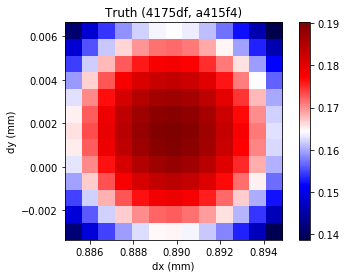

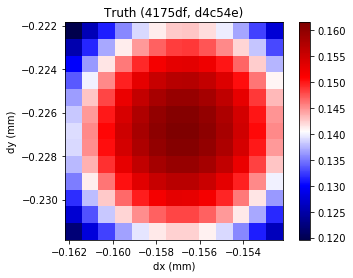

In [32]:
def xy_grid(p1, p2, spills, dx, dy, delta, res, alpha=0.5, visualize=False, **kwargs):
    x_bins, y_bins = np.meshgrid(np.linspace(dx-delta, dx+delta, res), np.linspace(dy-delta, dy+delta, res))
    score_grid = np.array([[score_spills(p1, p2, *spills, dx=x, dy=y, alpha=alpha, ndivs=NDIVS, **kwargs) \
                   for x in np.linspace(dx-delta, dx+delta, res)] \
                  for y in np.linspace(dy-delta, dy+delta, res)])
    
    if visualize:
        plt.figure()
        plt.imshow(score_grid, extent=[dx-delta, dx+delta, dy-delta, dy+delta], cmap='seismic', \
                   origin='lower');
        plt.title('Truth ({}, {})'.format(p1[:6], p2[:6]))
        plt.xlabel('dx (mm)')
        plt.ylabel('dy (mm)')
        plt.colorbar()
        plt.show()
    return score_grid, x_bins, y_bins

# test with truth values
for other in OTHERS:
    xy_grid(ROOT, other, spills, *(dxy_truth[other]), .005, 13, phi=dphi_truth[other], \
            ux=u_truth[other][0], uxy=u_truth[other][1], uy=u_truth[other][2], \
            alpha=0.1, nmax=3, visualize=True);

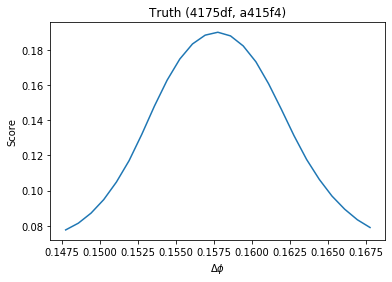

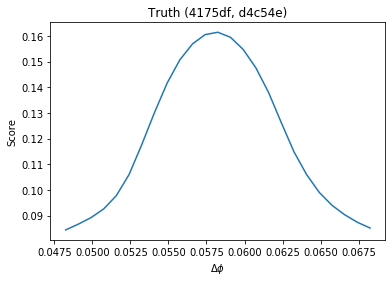

In [33]:
def phi_grid(p1, p2, spills, phi, delta, res, visualize=True, **kwargs):
    plt.figure()
    phi_bins = np.linspace(phi-delta, phi+delta, res)
    score_grid = np.array([score_spills(p1, p2, *spills, phi=phi_i, ndivs=NDIVS, **kwargs) for phi_i in phi_bins])
    
    if visualize:
        plt.plot(phi_bins, score_grid)
        plt.title('Truth ({}, {})'.format(p1[:6], p2[:6]))
        plt.xlabel(r'$\Delta\phi$')
        plt.ylabel('Score')
        plt.show()
    
    return score_grid, phi_bins
    
for other in OTHERS:
    phi_grid(ROOT, other, spills, dphi_truth[other], .01, 25, dx=dxy_truth[other][0], dy=dxy_truth[other][1], \
            ux=u_truth[other][0], uxy=u_truth[other][1], uy=u_truth[other][2], nmax=3, alpha=0.1);

In [34]:
def get_max(grid, *bins):
    idx = np.unravel_index(np.argmax(grid), grid.shape)
    return tuple(b[idx] for b in bins)

Now with a combination of grid searches and Nelder-Mead optimization, we can find approximate $(x, y, \phi)$ coordinates.

In [35]:
# start with increasingly precise grid searches in x,y,phi
xyphi = [{}]

def xy_phi_grid(p1, p2, spills, dx_guess, dy_guess, phi_guess, delta_xy, delta_phi, res_xy=11, res_phi=15, \
                visualize=None, **kwargs):

    if visualize and visualize != 'best' and visualize != 'all': 
        raise ValueError('"visualize" must be one of "best"/"all"')
    
    dx_result = dx_guess
    dy_result = dy_guess
    phi_result = phi_guess
    score_grid_best = None

    max_score = 0
    for phi_i in np.linspace(phi_guess-delta_phi, phi_guess+delta_phi, res_phi):
        if visualize=='all':
            print("phi={:.4f}".format(phi_i))
        score_grid, x_bins, y_bins = xy_grid(p1, p2, spills, dx_guess, dy_guess, delta_xy, res_xy, \
                                    phi=phi_i, visualize=(visualize=='all'), **kwargs)

        grid_max = np.amax(score_grid)
        if grid_max > max_score:
            max_score = grid_max

            dx_result, dy_result = get_max(score_grid, x_bins, y_bins)

            phi_result = phi_i
            
            score_grid_best = score_grid

    if visualize == 'best':
        plt.figure()
        plt.xlabel('dx (mm)')
        plt.ylabel('dy (mm)')
        plt.imshow(score_grid_best, extent=[dx_guess-delta_xy, dx_guess+delta_xy, dy_guess-delta_xy, dy_guess+delta_xy], \
                   cmap='seismic', origin='lower')
        plt.colorbar()
        plt.title(r'$\phi = {:.4}, ({}, {})$'.format(phi_result, p1[:6], p2[:6]))
        plt.show()
            
    return dx_result, dy_result, phi_result

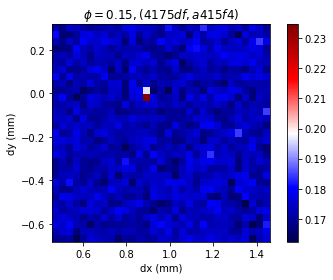

In [37]:
ITER = 0

# do the initial iteration separately
xyphi[ITER][OTHERS[0]] = xy_phi_grid(ROOT, OTHERS[0], spills, *dxy_coarse[OTHERS[0]], 0, 0.5, 0.15, 31, 15, alpha=0.3, nmax=3, visualize='best')

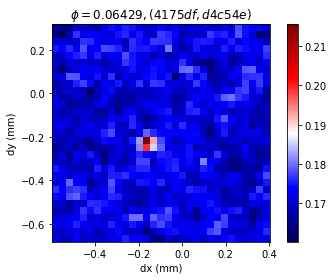

In [38]:
ITER = 0
xyphi[ITER][OTHERS[1]] = xy_phi_grid(ROOT, OTHERS[1], spills, *dxy_coarse[OTHERS[1]], 0, 0.5, 0.15, 31, 15, alpha=0.3, nmax=3, visualize='best')

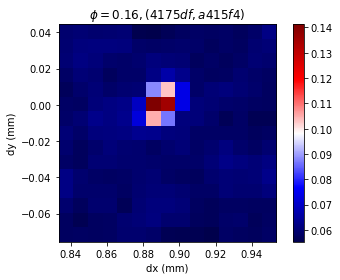

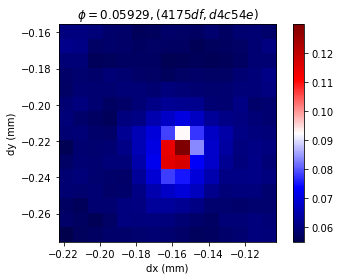

In [39]:
ITER = 1

if len(xyphi) <= ITER:
    xyphi.append({})
else:
    xyphi[ITER] = {}

for other in OTHERS:
    xyphi[ITER][other] = xy_phi_grid(ROOT, other, spills, *xyphi[ITER-1][other], 0.06, .02, 15, 9, alpha=0.1, nmax=5, visualize='best')

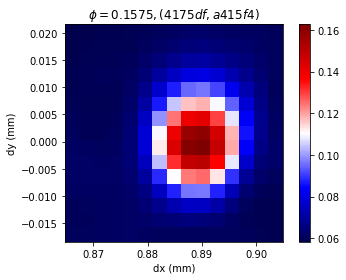

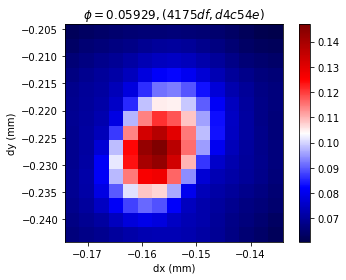

In [40]:
ITER = 2

if len(xyphi) <= ITER:
    xyphi.append({})
else:
    xyphi[ITER] = {}

for other in OTHERS:
    xyphi[ITER][other] = xy_phi_grid(ROOT, other, spills, *xyphi[ITER-1][other], .02, .005, 15, 9, alpha=0.1, nmax=5, visualize='best')

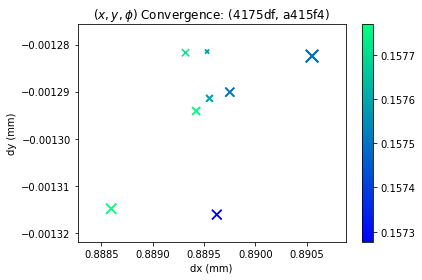

Success!


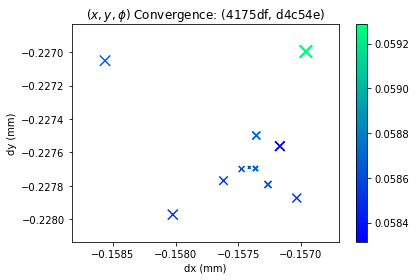

Success!


In [41]:
# if we have a good enough initial guess, we can use an optimizer to find the maximum

ITER = 3

def f_xyphi(x, p1, p2, spills):
    return 1 - score_spills(p1, p2, *spills, dx=x[0], dy=x[1], phi=x[2], nmax=25, alpha=0.1)

if len(xyphi) <= ITER:
    xyphi.append({})
else:
    xyphi[ITER] = {}

for other in OTHERS:
    guess = np.array(xyphi[ITER-1][other])
    progress = [guess]
    res = scipy.optimize.minimize(f_xyphi, guess, args=(ROOT, other, spills), method='Nelder-Mead', callback = lambda xk: progress.append(xk))
    
    progress_arr = np.array(progress).transpose()
    
    xmin = np.amin(progress_arr[0])
    xmax = np.amax(progress_arr[0])
    ymin = np.amin(progress_arr[1])
    ymax = np.amax(progress_arr[1])
    
    plt.xlim(xmin-(xmax-xmin)/6, xmax+(xmax-xmin)/6)
    plt.ylim(ymin-(ymax-ymin)/6, ymax+(ymax-ymin)/6)
    
    plt.title(r'$(x, y, \phi)$ Convergence: ({}, {})'.format(ROOT[:6], other[:6]))
    plt.xlabel('dx (mm)')
    plt.ylabel('dy (mm)')
    plt.scatter(progress_arr[0], progress_arr[1], c=progress_arr[2], \
                s=160*np.arange(progress_arr.shape[1]+1)[::-1] / progress_arr.shape[1], cmap='winter', marker='x')
    plt.colorbar()
    plt.show()
    
    if res.success:
        print("Success!")
        dx, dy, phi = res.x
        xyphi[-1][other] = (dx, dy, phi)
    else: print("Failed:", res.message)

Now we can do a similar process for $U$.

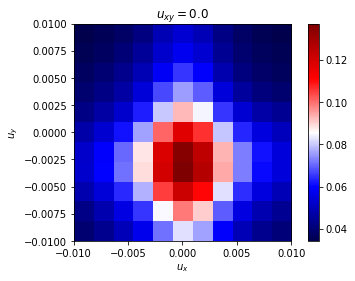

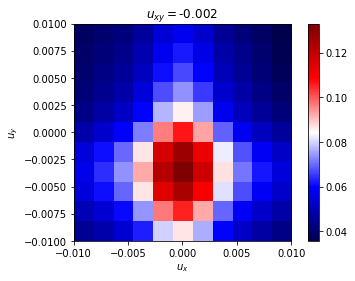

In [43]:
def u_grid(p1, p2, spills, ux, uxy, uy, delta, res, visualize=None, **kwargs):

    if visualize and visualize != 'best' and visualize != 'all': 
        raise ValueError('"visualize" must be one of "best"/"all"')
    
    ux_result = ux
    uxy_result = uxy
    uy_result = uy
    score_grid_best = None

    max_score = 0
    for uxy_i in np.linspace(uxy-delta, uxy+delta, res):
        
        score_grid = np.array([[score_spills(p1, p2, *spills, ux=ux_i, uxy=uxy_i, uy=uy_i, **kwargs) \
                   for ux_i in np.linspace(ux-delta, ux+delta, res)] \
                  for uy_i in np.linspace(uy-delta, uy+delta, res)])
        
        if visualize=='all':
            plt.figure()
            plt.imshow(score_grid, extent=[ux-delta, ux+delta, uy-delta, uy+delta], \
                       cmap='seismic', origin='lower')
            plt.colorbar()
            plt.title(r'$u_{xy} =$' + '{:.4}'.format(uxy_i))
            plt.show()

        grid_max = np.amax(score_grid)
        if grid_max > max_score:
            max_score = grid_max

            ux_bins, uy_bins = np.meshgrid(np.linspace(ux-delta, ux+delta, res), np.linspace(uy-delta, uy+delta, res))
            ux_result, uy_result = get_max(score_grid, ux_bins, uy_bins)

            uxy_result = uxy_i
            
            score_grid_best = score_grid

    if visualize == 'best':
        plt.figure()
        plt.imshow(score_grid_best, extent=[ux-delta, ux+delta, uy-delta, uy+delta], \
                   cmap='seismic', origin='lower')
        plt.colorbar()
        plt.title(r'$u_{xy} =$' + '{:.4}'.format(uxy_result))
        plt.xlabel(r'$u_x$')
        plt.ylabel(r'$u_y$')
        plt.show()
            
    return ux_result, uxy_result, uy_result

u_guess = [{}]

for other in OTHERS:
    u_guess[0][other] = u_grid(ROOT, other, spills, 0, 0, 0, 1e-2, 11, nmax=5, visualize='best', alpha=0.05, \
           dx=xyphi[-1][other][0], dy=xyphi[-1][other][1], phi=xyphi[-1][other][2],)

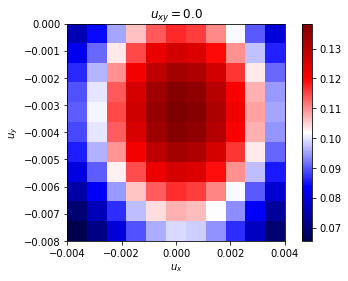

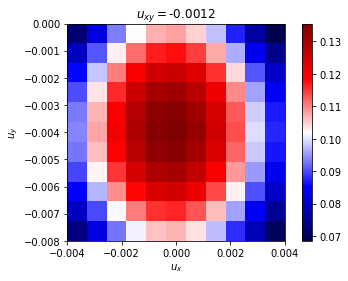

In [44]:
ITER = 1

if len(u_guess) <= ITER:
    u_guess.append({})
else:
    u_guess[ITER] = {}

for other in OTHERS:
    u_guess[ITER][other] = u_grid(ROOT, other, spills, *u_guess[ITER-1][other], 4e-3, 11, nmax=5, alpha=0.05, \
           dx=xyphi[-1][other][0], dy=xyphi[-1][other][1], phi=xyphi[-1][other][2], visualize='best')

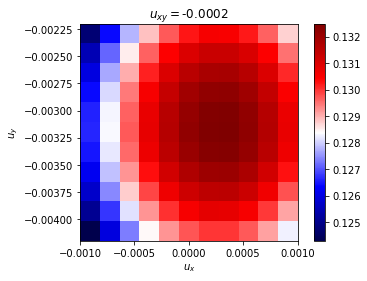

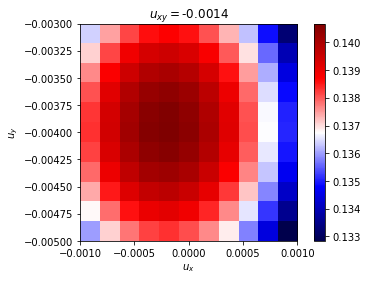

In [45]:
ITER = 2

if len(u_guess) <= ITER:
    u_guess.append({})
else:
    u_guess[ITER] = {}

for other in OTHERS:
    u_guess[ITER][other] = u_grid(ROOT, other, spills, *u_guess[ITER-1][other], 1e-3, 11, nmax=7, alpha=0.05, \
           dx=xyphi[-1][other][0], dy=xyphi[-1][other][1], phi=xyphi[-1][other][2], visualize='best')

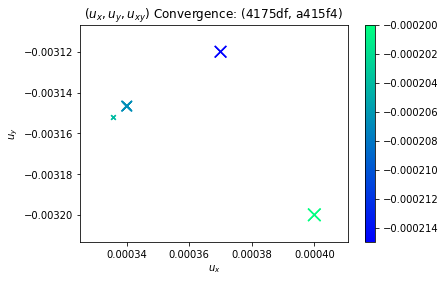

Success!


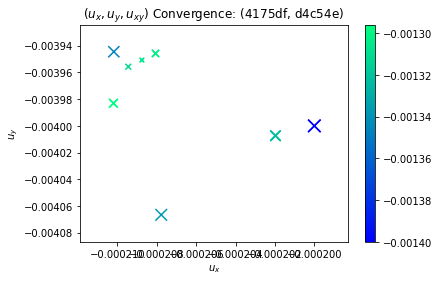

Success!


In [46]:
ITER = 3

if len(u_guess) <= ITER:
    u_guess.append({})
else:
    u_guess[ITER] = {}

def f_u(x, p1, p2, spills, dx, dy, phi):
    return 1 - score_spills(p1, p2, *spills, dx=dx, dy=dy, phi=phi, \
                            ux=x[0], uxy=x[1], uy=x[2], 
                            nmax=10, alpha=0.03)

for other in OTHERS:
    guess = np.array(u_guess[ITER-1][other])
    progress = [guess]
    res = scipy.optimize.minimize(f_u, guess, args=(ROOT, other, spills, *xyphi[-1][other]), method='Nelder-Mead', \
                                  options={'xatol': 1e-5}, callback=lambda xk: progress.append(xk))
    
    progress_arr = np.array(progress).transpose()
    
    xmin = np.amin(progress_arr[0])
    xmax = np.amax(progress_arr[0])
    ymin = np.amin(progress_arr[2])
    ymax = np.amax(progress_arr[2])
    
    plt.xlim(xmin-(xmax-xmin)/6, xmax+(xmax-xmin)/6)
    plt.ylim(ymin-(ymax-ymin)/6, ymax+(ymax-ymin)/6)
    
    plt.title(r'$(u_x, u_y, u_{xy})$ Convergence: ' + '({}, {})'.format(ROOT[:6], other[:6]))
    plt.xlabel(r'$u_x$')
    plt.ylabel(r'$u_y$')
    plt.scatter(progress_arr[0], progress_arr[2], c=progress_arr[1], \
                s=160*np.arange(progress_arr.shape[1]+1)[::-1] / progress_arr.shape[1], cmap='winter', marker='x')
    plt.colorbar()
    plt.show()
    
    if res.success:
        print("Success!")
        u_guess[ITER][other] = res.x
    else: print("Failed:", res.message)

Finally, we do an optimization with all six parameters:

In [47]:
def f_tot(x, p1, p2, spills):
    return 1 - score_spills(p1, p2, *spills, dx=x[0], dy=x[1], phi=x[2], \
                            ux=x[3], uxy=x[4], uy=x[5], 
                            nmax=15, alpha=0.05)

alignments = {ROOT: (0,0,0,0,0,0)}

for other in OTHERS:
    guess = np.array([*xyphi[-1][other], *u_guess[-1][other]])
    res = scipy.optimize.minimize(f_tot, guess, args=(ROOT, other, spills), method='Nelder-Mead', \
                                  options={'xatol': 1e-5}, callback=lambda xk: print(xk))
    
    if res.success:
        print("Success!")
        alignments[other] = res.x
    else: print("Failed:", res.message)

[ 8.89529457e-01 -1.28149072e-03  1.57586991e-01  3.35740741e-04
 -2.03991770e-04 -3.15226337e-03]
[ 8.89529457e-01 -1.28149072e-03  1.57586991e-01  3.35740741e-04
 -2.03991770e-04 -3.15226337e-03]
[ 8.89529457e-01 -1.28149072e-03  1.57586991e-01  3.35740741e-04
 -2.03991770e-04 -3.15226337e-03]
[ 8.89529457e-01 -1.28149072e-03  1.57586991e-01  3.35740741e-04
 -2.03991770e-04 -3.15226337e-03]
[ 8.89529457e-01 -1.28149072e-03  1.57586991e-01  3.35740741e-04
 -2.03991770e-04 -3.15226337e-03]
[ 8.89529457e-01 -1.28149072e-03  1.57586991e-01  3.35740741e-04
 -2.03991770e-04 -3.15226337e-03]
[ 8.89529457e-01 -1.28149072e-03  1.57586991e-01  3.35740741e-04
 -2.03991770e-04 -3.15226337e-03]
[ 8.89529457e-01 -1.28149072e-03  1.57586991e-01  3.35740741e-04
 -2.03991770e-04 -3.15226337e-03]
[ 8.89529457e-01 -1.28149072e-03  1.57586991e-01  3.35740741e-04
 -2.03991770e-04 -3.15226337e-03]
[ 8.89393992e-01 -1.29515519e-03  1.57088633e-01  3.39320726e-04
 -2.06166922e-04 -3.18587578e-03]
[ 8.897498

[ 8.89231977e-01  1.07275924e-03  1.57848345e-01  4.08253843e-04
 -3.21755312e-04 -3.74194359e-03]
[ 8.89231977e-01  1.07275924e-03  1.57848345e-01  4.08253843e-04
 -3.21755312e-04 -3.74194359e-03]
[ 8.89231977e-01  1.07275924e-03  1.57848345e-01  4.08253843e-04
 -3.21755312e-04 -3.74194359e-03]
[ 8.89236926e-01  1.09167396e-03  1.57840881e-01  4.09277294e-04
 -3.23756199e-04 -3.73503640e-03]
[ 8.89231684e-01  1.10612562e-03  1.57849325e-01  4.09331441e-04
 -3.24190010e-04 -3.74063194e-03]
[ 8.89230775e-01  1.08785897e-03  1.57858573e-01  4.08253250e-04
 -3.23022901e-04 -3.74535341e-03]
[ 8.89230775e-01  1.08785897e-03  1.57858573e-01  4.08253250e-04
 -3.23022901e-04 -3.74535341e-03]
[ 8.89230775e-01  1.08785897e-03  1.57858573e-01  4.08253250e-04
 -3.23022901e-04 -3.74535341e-03]
[ 8.89230775e-01  1.08785897e-03  1.57858573e-01  4.08253250e-04
 -3.23022901e-04 -3.74535341e-03]
[ 8.89240547e-01  1.08379233e-03  1.57843338e-01  4.07034334e-04
 -3.24172693e-04 -3.73850258e-03]
[ 8.892405

[ 8.89667641e-01  1.11693714e-03  1.57838109e-01  1.22304842e-04
 -5.45745870e-04 -3.77647761e-03]
[ 8.89587948e-01  1.16232250e-03  1.57873649e-01  1.48686776e-04
 -5.26419302e-04 -3.78852387e-03]
[ 8.89598905e-01  1.21993957e-03  1.57879488e-01  1.52032472e-04
 -5.28552952e-04 -3.80123100e-03]
[ 8.89636897e-01  1.21248398e-03  1.57861579e-01  1.16261541e-04
 -5.56976697e-04 -3.77106912e-03]
[ 8.89557323e-01  1.21962059e-03  1.57862579e-01  1.53957454e-04
 -5.24973502e-04 -3.80018332e-03]
[ 8.89522263e-01  1.21479419e-03  1.57851489e-01  1.68177264e-04
 -5.15886898e-04 -3.76960288e-03]
[ 8.89522263e-01  1.21479419e-03  1.57851489e-01  1.68177264e-04
 -5.15886898e-04 -3.76960288e-03]
[ 8.89522263e-01  1.21479419e-03  1.57851489e-01  1.68177264e-04
 -5.15886898e-04 -3.76960288e-03]
[ 8.89522263e-01  1.21479419e-03  1.57851489e-01  1.68177264e-04
 -5.15886898e-04 -3.76960288e-03]
[ 8.89506256e-01  1.27713820e-03  1.57842923e-01  1.20835643e-04
 -5.52837704e-04 -3.78101142e-03]
[ 8.895062

[-1.57026543e-01 -2.26908373e-01  5.82273106e-02 -2.14674972e-04
 -1.34402532e-03 -3.96539111e-03]
[-1.57026543e-01 -2.26908373e-01  5.82273106e-02 -2.14674972e-04
 -1.34402532e-03 -3.96539111e-03]
[-1.57026543e-01 -2.26908373e-01  5.82273106e-02 -2.14674972e-04
 -1.34402532e-03 -3.96539111e-03]
[-1.56932663e-01 -2.26930798e-01  5.82786421e-02 -2.13104406e-04
 -1.34998755e-03 -3.98246176e-03]
[-1.56932663e-01 -2.26930798e-01  5.82786421e-02 -2.13104406e-04
 -1.34998755e-03 -3.98246176e-03]
[-1.56925995e-01 -2.26789354e-01  5.82704172e-02 -2.12823346e-04
 -1.34669262e-03 -4.03597787e-03]
[-1.57003361e-01 -2.26916419e-01  5.83074390e-02 -2.11676804e-04
 -1.35575505e-03 -4.00466703e-03]
[-1.57003361e-01 -2.26916419e-01  5.83074390e-02 -2.11676804e-04
 -1.35575505e-03 -4.00466703e-03]
[-1.57025089e-01 -2.26916788e-01  5.82802079e-02 -2.12530983e-04
 -1.37685031e-03 -4.00922130e-03]
[-1.57025089e-01 -2.26916788e-01  5.82802079e-02 -2.12530983e-04
 -1.37685031e-03 -4.00922130e-03]
[-1.570250

In [48]:
np.set_printoptions(precision=4)

for p in PHONE_LIST:
    print('{}:'.format(p))
    print("Measured: ", alignments[p])
    print("Truth:", align_truth[p])
    print("Diff:", alignments[p] - align_truth[p])
    print()

4175df1b613b494e:
Measured:  (0, 0, 0, 0, 0, 0)
Truth: [ 0.0000e+00  0.0000e+00  0.0000e+00 -4.1345e-06 -8.4534e-06 -1.7284e-05]
Diff: [0.0000e+00 0.0000e+00 0.0000e+00 4.1345e-06 8.4534e-06 1.7284e-05]

a415f48b88bf4087:
Measured:  [ 8.8954e-01  1.2167e-03  1.5782e-01  1.1363e-04 -5.5475e-04 -3.7760e-03]
Truth: [ 8.8987e-01  1.6442e-03  1.5777e-01  1.2576e-04 -1.3403e-03 -3.5076e-03]
Diff: [-3.2468e-04 -4.2749e-04  4.2895e-05 -1.2131e-05  7.8554e-04 -2.6838e-04]

d4c54e984d644540:
Measured:  [-1.5701e-01 -2.2683e-01  5.8231e-02 -1.9800e-04 -1.4831e-03 -4.1394e-03]
Truth: [-0.1572 -0.2268  0.0582 -0.0007 -0.0019 -0.0037]
Diff: [ 1.8156e-04  1.4122e-05 -1.5659e-05  5.1531e-04  4.4775e-04 -4.5109e-04]



In [49]:
# output corrected coordinates

alignments = align_truth

os.makedirs(os.path.join(DIR, 'corr'), exist_ok=True)
for iphone in PHONE_LIST:
    
    for spl in spills:
        for t in spl[iphone]:

            fspl = Spill.get_file(iphone, t)

            x_sensor = (fspl['x'] - RES_X / 2) * PIX_SIZE
            y_sensor = (fspl['y'] - RES_Y / 2) * PIX_SIZE

            ux, uxy, uy = alignments[iphone][3:]
            u = np.array([[ux, uxy], [uxy, uy]])
            x_lab, y_lab = sensor_map(x_sensor, y_sensor, *alignments[iphone])
            np.savez('{}/corr/{}_p{}_t{}.npz'.format(DIR, PREFIX, iphone, t), x=x_lab, y=y_lab, \
                 t=fspl['t'], align=alignments[iphone])
            fspl.close()


# IV. Efficiency #

The general strategy for finding efficiency is simple enough.  We want to count the total number of coincidences on each sensor pair, subtract out the noise of different particles hitting the same region, and divide by the average number of particles that hit each sensor during the overlapping part of the frame.  Assuming the alignment has been done well, counting the coincidences should be easy.  For the background, if we have $N$ and $M$ uncorrelated hits on a pair of sensors, each with a distribution $P(\vec{r})$:

\begin{equation}
E(n_\mathrm{coinc})=NM \int d^2\vec{r_1} P(\vec{r_1}) \int d^2\vec{r_2} P(\vec{r_2}) \ \ \Theta(\vec{r_1} - \vec{r_2})
\end{equation}

where $\Theta{r}$ is a $0$ or $1$ valued threshold function which determines whether two points are considered a coincidence.  If $P(\vec{r})$ is roughly constant on the scale of $\Theta$, we can treat it like a Delta function:

\begin{equation}
E(n_\mathrm{coinc}) \approx NM \int d^2\vec{r_1} P(\vec{r_1})^2
\end{equation}

and this integral can be evaluated numerically on the dataset.

Finally, to find the average number of particles hitting a single frame in the overlapping time window, we note that if the beam is on for the full duration of both frames, which overlap for some fraction $f$ of the total frame duration:

\begin{equation}
n_\mathrm{overlap} \approx f \left(\frac{N+M}{2}\right)
\end{equation}

On the other hand, if the beam starts or stops during one frame, but the other frame receives the full intensity (i.e. the start or stop does not occur in the overlap window):

\begin{equation}
n_\mathrm{overlap} \approx f \max\{N, M\},
\qquad
\left|\ln\left(\frac{N}{M}\right)\right| < -\ln f
\end{equation}

and if the start or stop *does* occur in the overlap window:

\begin{equation}
n_\mathrm{overlap} \approx \min\{N, M\},
\qquad
\left|\ln\left(\frac{N}{M}\right)\right| > -\ln f
\end{equation}

In [50]:
# iterator through overlapping frames
def gen_overlaps(spill, phones):
    phones = np.array(phones)
    times = [spill[p].copy() for p in phones]
    t_ijk = np.array([t.pop(0) for t in times])
    while True:
        overlap = calculate_overlap(1, *t_ijk)
        if overlap:
            sort_idx = np.argsort(t_ijk)
            yield phones[sort_idx], t_ijk[sort_idx], overlap

        # replace the earliest time, if possible
        p_earliest = np.argmin(t_ijk)
        if not times[p_earliest]: break
        t_ijk[p_earliest] = times[p_earliest].pop(0)

# a faster method for doing the above two sets at a time
def gen_overlap_pairs(spill, p1, p2):
    
    ORDER = [1, 0, 2]
    
    phones_yld = np.array([])
    times_yld = np.array([])
    overlaps_yld = []
    
    for phones, times, overlap in gen_overlaps(spill, (p1,p2)):
        if not overlaps_yld:
            # the cache is empty, so just populate it
            phones_yld = phones
            times_yld = times
            overlaps_yld.append(overlap)
            
        elif phones[0] == phones_yld[-1] and times[0] == times_yld[-1]:
            # we have a duplicate, so add the non-repeating entry to the list, and re-order
            phones_yld = np.hstack([phones_yld, [phones[1]]])
            times_yld = np.hstack([times_yld, [times[1]]])
            overlaps_yld.append(overlap)
            
            yield phones_yld[ORDER], times_yld[ORDER], overlaps_yld
            
            phones_yld = np.array([])
            times_yld = np.array([])
            overlaps_yld = []
            
        else:
            # we're either at the end of the spill, or we missed a frame
            yield phones_yld, times_yld, overlaps_yld
            phones_yld = phones
            times_yld = times
            overlaps_yld = [overlap]
    
    # handle the end of the spill if there's anything to yield
    if overlaps_yld:
        yield phones_yld, times_yld, overlaps_yld

In [51]:
# find geometrical factors
X_MIN = {}
Y_MIN = {}

X_SIZE = {}
Y_SIZE = {}

for c in COMBINATIONS:
    
    # get first frames
    spl = spills[0]
    f_ij = [Spill.get_file(p, spl[p][0], filetype='corr') for p in c]
    
    x_offsets = [f['align'][0] for f in f_ij]
    y_offsets = [f['align'][1] for f in f_ij]
    max_phi, max_ux, max_uxy, max_uy = np.amax(np.abs([f['align'][2:] for f in f_ij]), axis=0)
    
    dx = np.diff(x_offsets)[0] / PIX_SIZE
    dy = np.diff(y_offsets)[0] / PIX_SIZE
    
    X_MIN[c] = max(x_offsets)-(RES_X*(max_ux+np.cos(max_phi)) + RES_Y*(max_uxy+np.sin(max_phi)))/2*PIX_SIZE
    Y_MIN[c] = max(y_offsets)-(RES_Y*(max_uy+np.cos(max_phi)) + RES_X*(max_uxy+np.sin(max_phi)))/2*PIX_SIZE
    
    X_SIZE[c] = int(RES_X*(max_ux+np.cos(max_phi))+RES_Y*(max_uxy+np.sin(max_phi)) - np.abs(dx)) + 1
    Y_SIZE[c] = int(RES_Y*(max_uy+np.cos(max_phi))+RES_X*(max_uxy+np.sin(max_phi)) - np.abs(dy)) + 1
    
    for f in f_ij: f.close()
        

In [52]:
# first perform cut with only hits in intersecting region in lab space

NOISE_INTERSECT = {}

# get alignment params
aligns = {}
for p in PHONE_LIST:
    f0 = Spill.get_file(p, spills[0][p][0], filetype='corr')
    aligns[p] = f0['align'].copy()
    f0.close()

for c in COMBINATIONS:
    # create new directories for permutations of intersections
    subdir = '_'.join(map(lambda p: str(p)[:6], np.sort(c)))
    os.makedirs(os.path.join(DIR, subdir), exist_ok=True)
    
    for pi in c:
        for spl in spills:
            for t in spl[pi]:
                fi = Spill.get_file(pi, t, filetype='corr')
                
                x_cut = fi['x']
                y_cut = fi['y']
                
                for pj in c:
                    if pi is pj: continue
                    
                    xj, yj = inverse_map(x_cut, y_cut, *aligns[pj])

                    intersect = (np.abs(xj) < lim_x) & (np.abs(yj) < lim_y)

                    x_cut = x_cut[intersect]
                    y_cut = y_cut[intersect]
                
                x_coords = (x_cut - X_MIN[c]) / PIX_SIZE
                y_coords = (y_cut - Y_MIN[c]) / PIX_SIZE

                np.savez('{}/{}/{}_p{}_t{}.npz'.format(DIR, subdir, PREFIX, pi, t), \
                     x=x_coords, y=y_coords, align=aligns[p])
                fi.close()
                
        

In order to find $\int d^2\vec{r_1} P(\vec{r_1})^2$, we note that for a histogram (i.e. with Poisson statistics), $E(N^2-N) = E(N^2) - E(N) = E((N-\bar{N})^2)) + E(N)^2 - E(N) = \sigma^2 + \mu^2 - \mu = \mu^2$

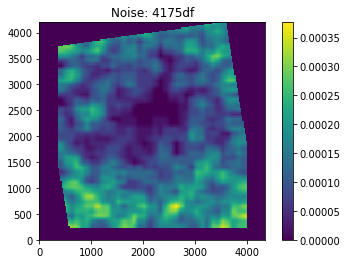

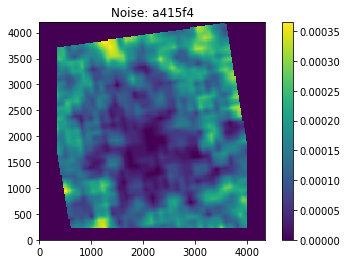

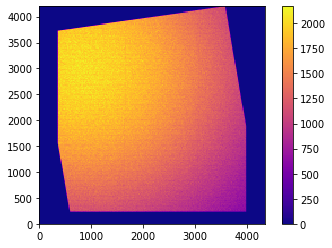

A_tot = 13143044.6656
A_eff = 12365001.633656368


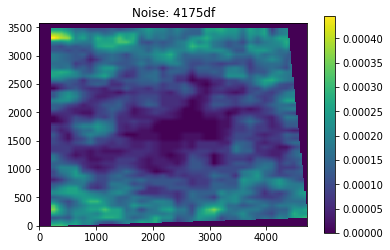

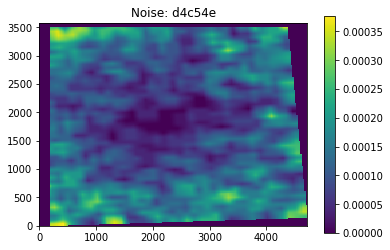

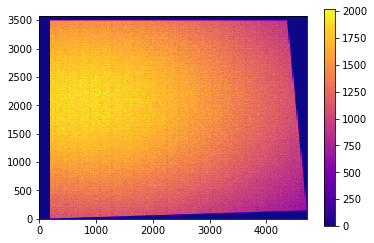

A_tot = 15017004.86055
A_eff = 14353315.53665323


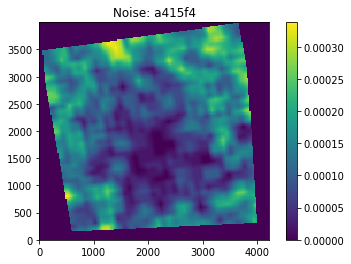

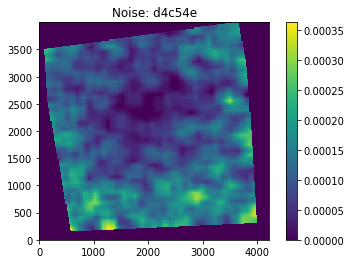

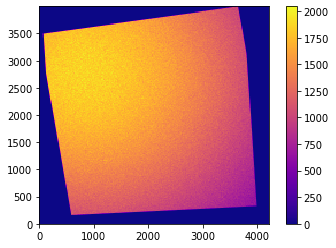

A_tot = 12732961.663575
A_eff = 12088002.181389095


In [53]:
# find the effective area
hist_side = 200

BEAM_PROFILE_CORR = {}
NOISE_INTERSECT = {}

for c in COMBINATIONS:
    profile = np.zeros((hist_side, hist_side))
    
    bx = np.linspace(0, X_SIZE[c]-1, hist_side+1)
    by = np.linspace(0, Y_SIZE[c]-1, hist_side+1)
    
    for spl in spills:
        for p in c:
            for t in spl[p]:
                f = Spill.get_file(p, t, filetype='_'.join(map(lambda pi: str(pi)[:6], np.sort(c))))
                profile += np.histogram2d(f['x'], f['y'], bins=(bx, by))[0]
                f.close()
    
    BEAM_PROFILE_CORR[c] = (profile*(profile-1)).sum() / profile.sum()**2 * profile.size / X_SIZE[c] / Y_SIZE[c] 
    
    # also handle noise
    bxx, byy = np.meshgrid(bx[:-1], by[:-1])
    for p in c:
        bxx_sensor, byy_sensor = inverse_map((bxx*PIX_SIZE + X_MIN[c]).flatten(), \
                                             (byy*PIX_SIZE + Y_MIN[c]).flatten(), \
                                             *aligns[p])
        
        # now map to coordinates of the noise histograms
        cut = (np.abs(bxx_sensor) < RES_X / 2 * PIX_SIZE) & (np.abs(byy_sensor) < RES_Y / 2 * PIX_SIZE)
        
        bxx_pix = (bxx_sensor / PIX_SIZE + RES_X / 2).astype(int)
        byy_pix = (byy_sensor / PIX_SIZE + RES_Y / 2).astype(int)
        
        bxx_cut = bxx_pix[cut]
        byy_cut = byy_pix[cut]
        values_cut = NOISE[p][bxx_cut, byy_cut]
        
        template = np.zeros((hist_side, hist_side))
        ixx, iyy = np.meshgrid(np.arange(hist_side), np.arange(hist_side))
        template[ixx.flatten()[cut], iyy.flatten()[cut]] = values_cut * X_SIZE[c] * Y_SIZE[c] / hist_side ** 2
        template[profile == 0] = 0
        
        NOISE_INTERSECT[(c, p)] = template
        
        plt.imshow(template, cmap='viridis', extent=[0, X_SIZE[c], 0, Y_SIZE[c]])
        plt.colorbar()
        plt.title('Noise: {}'.format(p[:6]))
        plt.show()
    
    plt.imshow(profile, cmap='plasma', extent=[0, X_SIZE[c], 0, Y_SIZE[c]])
    plt.colorbar()
    plt.show()
    
    print('A_tot = {}'.format(np.count_nonzero(profile) * X_SIZE[c]*Y_SIZE[c] / profile.size))
    print('A_eff = {}'.format(1/BEAM_PROFILE_CORR[c]))
    

In [54]:
# now adjust for efficiency differences

TOTAL_HITS = {}

for c in COMBINATIONS:
    for p in c: TOTAL_HITS[(c, p)] = 0
    
    for spl in spills:
        for p in c:
            for t in spl[p]:
                f = Spill.get_file(p, t, filetype='_'.join(map(lambda pi: str(pi)[:6], np.sort(c))))
                
                TOTAL_HITS[(c, p)] += f.f.x.size - NOISE_INTERSECT[(c, p)].sum()
                
                f.close()
                
print({c: TOTAL_HITS[(c,c[0])] / TOTAL_HITS[(c, c[1])] for c in COMBINATIONS})

{('4175df1b613b494e', 'a415f48b88bf4087'): 1.0000496798185332, ('4175df1b613b494e', 'd4c54e984d644540'): 1.000357915923076, ('a415f48b88bf4087', 'd4c54e984d644540'): 1.000007068564269}


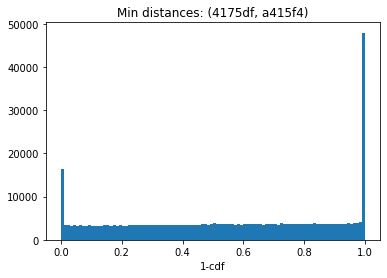

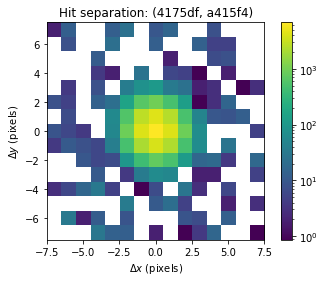

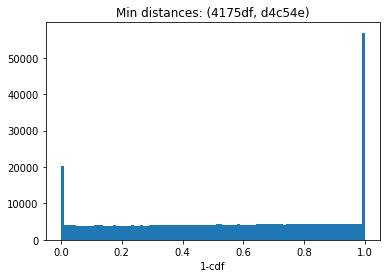

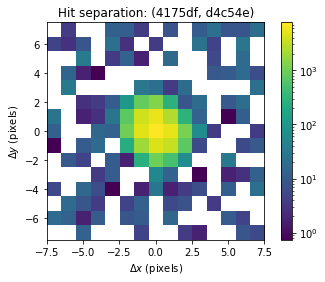

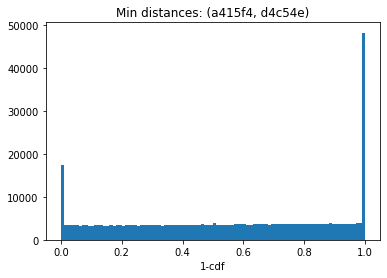

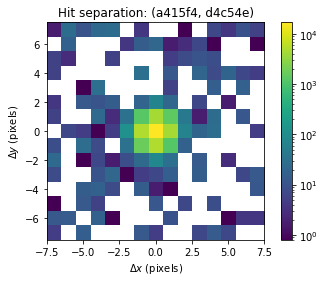

In [58]:
# at this point, we can measure the distribution of distances between hits
xy_hists = {}

ndivs = 13
survival_size = 100
xy_size = 15

xy_r = (xy_size - 1)/2
for c in COMBINATIONS:
    survival_tot = np.zeros(survival_size)
    xy_hists[c] = np.zeros((xy_size, xy_size))
    
    for spl in spills[:10]:
        for phones, times, overlap in gen_overlaps(spl, c):
            f_ij = [Spill.get_file(p, t, filetype='_'.join(map(lambda p: str(p)[:6], np.sort(phones)))) \
                 for p, t in zip(phones, times)]

            x1 = f_ij[0]['x']
            y1 = f_ij[0]['y']
            x2 = f_ij[1]['x']
            y2 = f_ij[1]['y']

            xmin = 0
            xmax = X_SIZE[c]
            ymin = 0
            ymax = Y_SIZE[c]

            divx = (xmax - xmin) / ndivs
            divy = (ymax - ymin) / ndivs

            # make interlaced cells
            x1_cells, y1_cells = divide_points(x1, y1, ndivs, limits=(xmin, xmax, ymin, ymax))
            x2_cells, y2_cells = divide_points(x2, y2, ndivs+1, limits=(xmin - divx/2, xmax + divx/2, ymin-divy/2, ymax+divy/2))

            for i,j in np.ndindex(ndivs, ndivs):
                group1 = (x1_cells == i) & (y1_cells == j) 
                if not group1.sum():
                    continue

                group2 = ((x2_cells == i) | (x2_cells == i+1)) & ((y2_cells == j) | (y2_cells == j+1))
                if not group2.sum():
                    continue

                rsquared_min = np.amin((x1[group1] - x2[group2].reshape(-1,1))**2 \
                                       + (y1[group1] - y2[group2].reshape(-1,1))**2, axis=0)

                density = group2.sum() / (4 * divx * divy)
                survival = np.exp(-rsquared_min * np.pi * density)

                survival_tot += np.histogram(survival, bins=survival_size)[0]

                xy_vals = np.dstack([x1[group1] - x2[group2].reshape(-1,1), \
                                     y1[group1] - y2[group2].reshape(-1,1)]).reshape(-1, 2).transpose()

                xy_hists[c] += np.histogram2d(xy_vals[0], xy_vals[1], \
                                bins=(np.arange(-xy_r-0.5, xy_r + 1.5), np.arange(-xy_r - 0.5, xy_r + 1.5)))[0]

            xy_hists[c] -= x1.size * x2.size * BEAM_PROFILE_CORR[c]

    plt.title('Min distances: ({}, {})'.format(c[0][:6], c[1][:6]))
    plt.xlabel('1-cdf')
    plt.hist(np.linspace(0, 1, survival_tot.size), weights=survival_tot, bins=survival_tot.size)
    plt.show()
    
    xx, yy = np.meshgrid(np.arange(-xy_r, xy_r + 1), np.arange(-xy_r, xy_r+1))
    plt.title('Hit separation: ({}, {})'.format(c[0][:6], c[1][:6]))
    plt.xlabel(r'$\Delta x$ (pixels)')
    plt.ylabel(r'$\Delta y$ (pixels)')
    
    plt.imshow(xy_hists[c], extent=[-xy_r-0.5, xy_r+0.5, -xy_r-0.5, xy_r+0.5], norm=LogNorm())
    plt.colorbar()
    plt.show()
    

In [ ]:
CONV_SIZE_LIST = [(3,3),(5,5),(3,3)]
CONV_SIZES = {COMBINATIONS[i]: CONV_SIZE_LIST[i] for i in range(len(COMBINATIONS))}

In [ ]:
eff_estimates = {c: [] for c in COMBINATIONS}

for c in COMBINATIONS:
    
    n_doubles = []
    n_tot = []
    
    eff_corrections = np.array([TOTAL_HITS[(c, p)] for p in c])
    eff_corrections /= TOTAL_HITS[(c, c[0])]
    
    for n_spills, spl in enumerate(spills):
        
        csize = CONV_SIZES[c]
        
        doubles_spl = 0
        tot_spl = 0
        
        print("{0:.1f}%".format(100*n_spills/len(spills)), end="\r")
        
        for phones, times, overlaps in gen_overlap_pairs(spl, *c): 
             
            f_ij = [Spill.get_file(p, t, filetype='_'.join(map(lambda p: str(p)[:6], np.sort(list(set(phones)))))) \
                         for p, t in zip(phones, times)]

            n_hits_tot = np.array([f['x'].size for f in f_ij])
            n_hits_corr = np.array([f['x'].size - NOISE_INTERSECT[(c,p)].sum() for f,p in zip(f_ij, phones)])

            sparse_j = [csr_matrix((np.ones(f['x'].size), (f['x'].astype(int), f['y'].astype(int))), \
                                  shape=(X_SIZE[c], Y_SIZE[c])) for f in f_ij[1:]]

            # this should work faster than a standard convolution for a sparse matrix
            q = np.zeros(len(sparse_j))
            center = np.array(csize) // 2
            for idx, idy in np.ndindex(csize):
                ix = f_ij[0]['x'].astype(int) + idx-center[0]
                iy = f_ij[0]['y'].astype(int) + idy-center[1]
                valid = (ix > 0) & (iy > 0) & (ix < X_SIZE[c]) & (iy < Y_SIZE[c])

                sparse_i = csr_matrix((np.ones(valid.sum()), (ix[valid], iy[valid])), shape=(X_SIZE[c], Y_SIZE[c]))
                for j in range(len(sparse_j)):
                    q[j] += sparse_i.multiply(sparse_j[j]).sum() / np.product(csize)

            i_first_last = (times[0] in np.array(spl[phones[0]])[[0,-1]])
            
            for j in range(len(sparse_j)):
                scale_factors = eff_corrections[(phones[[0, j+1]] == np.array(c).reshape(-1, 1)).argmax(axis=1)]
                hits_scaled = n_hits_corr[[0, j+1]] / scale_factors
                
                j_first_last = times[j+1] in np.array(spl[phones[j+1]])[[0, -1]]
                
                # see if we're at the beginning or end of a spill
                if i_first_last or j_first_last:
                    
                    if min(hits_scaled) <= 0 \
                    or np.abs(np.log(hits_scaled[0]/hits_scaled[1])) < np.log(1/overlaps[j]):
                        tot_spl += overlaps[j] * hits_scaled.max()
                    else:
                        tot_spl += hits_scaled.min()
                    
                else:
                    tot_spl += overlaps[j] * np.mean(hits_scaled)
            
            
                doubles_spl += (q[j] - np.product(n_hits_tot[[0, j+1]]) * BEAM_PROFILE_CORR[c]) * np.product(csize)
        
        n_doubles.append(doubles_spl)
        n_tot.append(tot_spl)

    print("100%", end="\r")
        
    # now find an unbiased ratio estimator (to first order) for each spill
    n_doubles = np.array(n_doubles)
    n_tot = np.array(n_tot)
    
    eff_estimates[c] = n_doubles / n_tot
    
    plt.title('Efficiency by spill: ({}, {})'.format(c[0][:6], c[1][:6]))
    ax1 = plt.subplot(111)
    ax1.hist(eff_estimates[c], bins=50)
    ax1.set_xlabel(r'$\epsilon$: {}'.format(c[1][:6]))
    
    ax2 = ax1.twiny()
    
    ax2.set_xlabel(r'$\epsilon$: {}'.format(c[0][:6]))
    
    ax2.xaxis.set_label_position('bottom')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.set_xlim(np.array(ax1.get_xlim()) / eff_corrections[1])
    ax2.spines['bottom'].set_position(('outward', 50))
    
    plt.show()

In [ ]:
mean_var = {p: [] for p in PHONE_LIST}

for c in COMBINATIONS:
    mean_c = np.mean(eff_estimates[c])
    var_c = np.var(eff_estimates[c]) / len(eff_estimates[c])
    
    
    scale = TOTAL_HITS[(c, c[0])] / TOTAL_HITS[(c, c[1])]
    mean_var[c[1]].append((mean_c, var_c))
    mean_var[c[0]].append((scale*mean_c, scale**2*var_c))
        

for p in PHONE_LIST:
    sum_wx = 0
    sum_w = 0
    
    print(p[:6])
    for mean, var in mean_var[p]:
        print(mean, "+/-", np.sqrt(var))
        sum_wx += mean/var
        sum_w += 1/var
    
    print("Total:", sum_wx/sum_w, "+\-", np.sqrt(1/sum_w))
    print()